1. Выберите ряд и постройте его модель ARIMA/GARCH
2. Попробуйте спрогнозировать график классическим ML

In [23]:
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [27]:
dowjones_closing = pd.read_csv("./Series/weekly-closings-of-the-dowjones-.csv")
dowjones_closing.head()

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [9]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return


def data_preprocessing(data):
    dowjones_closing_series = data["Close"].dropna()
    series = boxcox(dowjones_closing_series, 0)
    series = np.diff(series, 1)
    return series

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


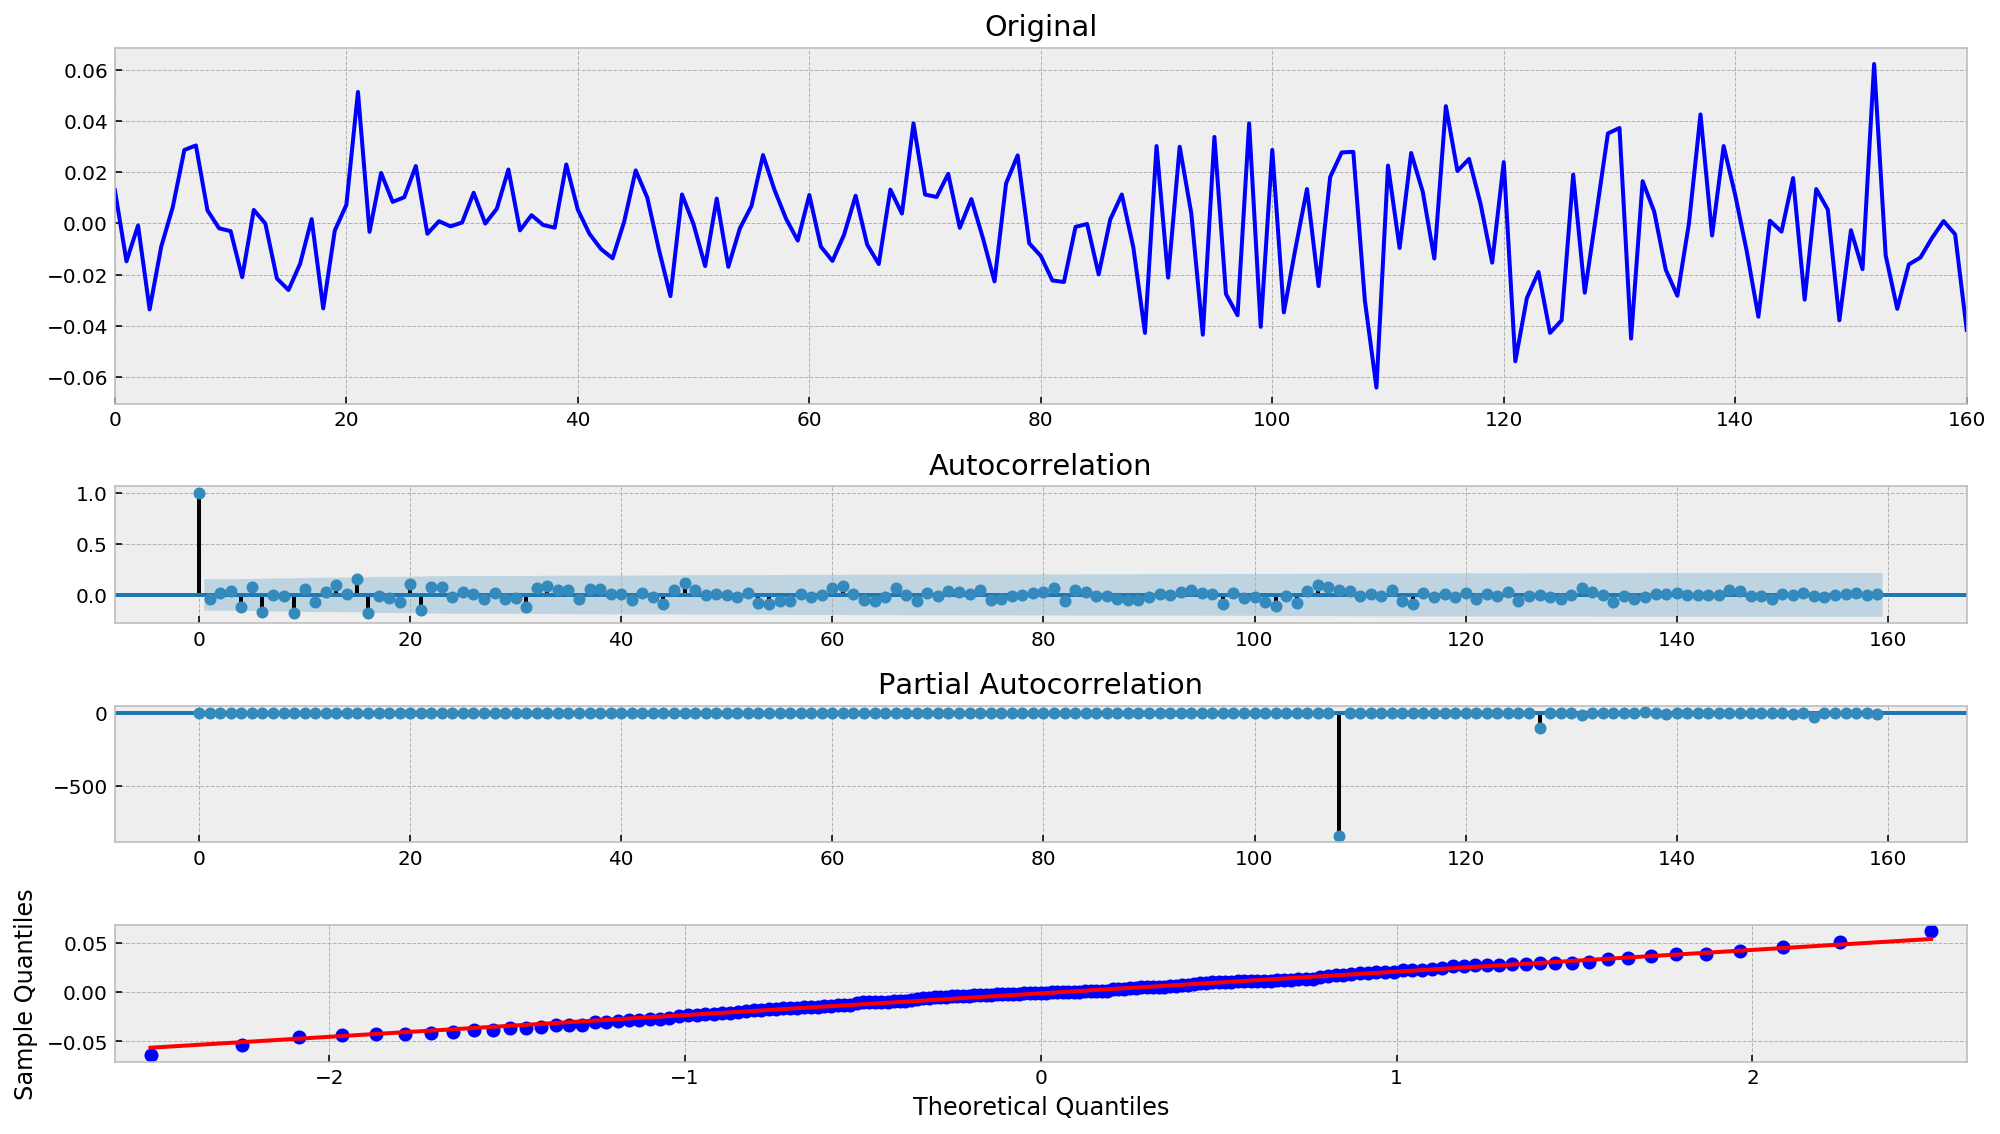

In [11]:
series = data_preprocessing(dowjones_closing)
tsplot(series, lags=len(series)-2)

### ARIMA

In [12]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

aic: -768.58241 | order: (3, 0, 2)


Results of Dickey-Fuller Test:
Test Statistic                -1.241126e+01
p-value                        4.338493e-23
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


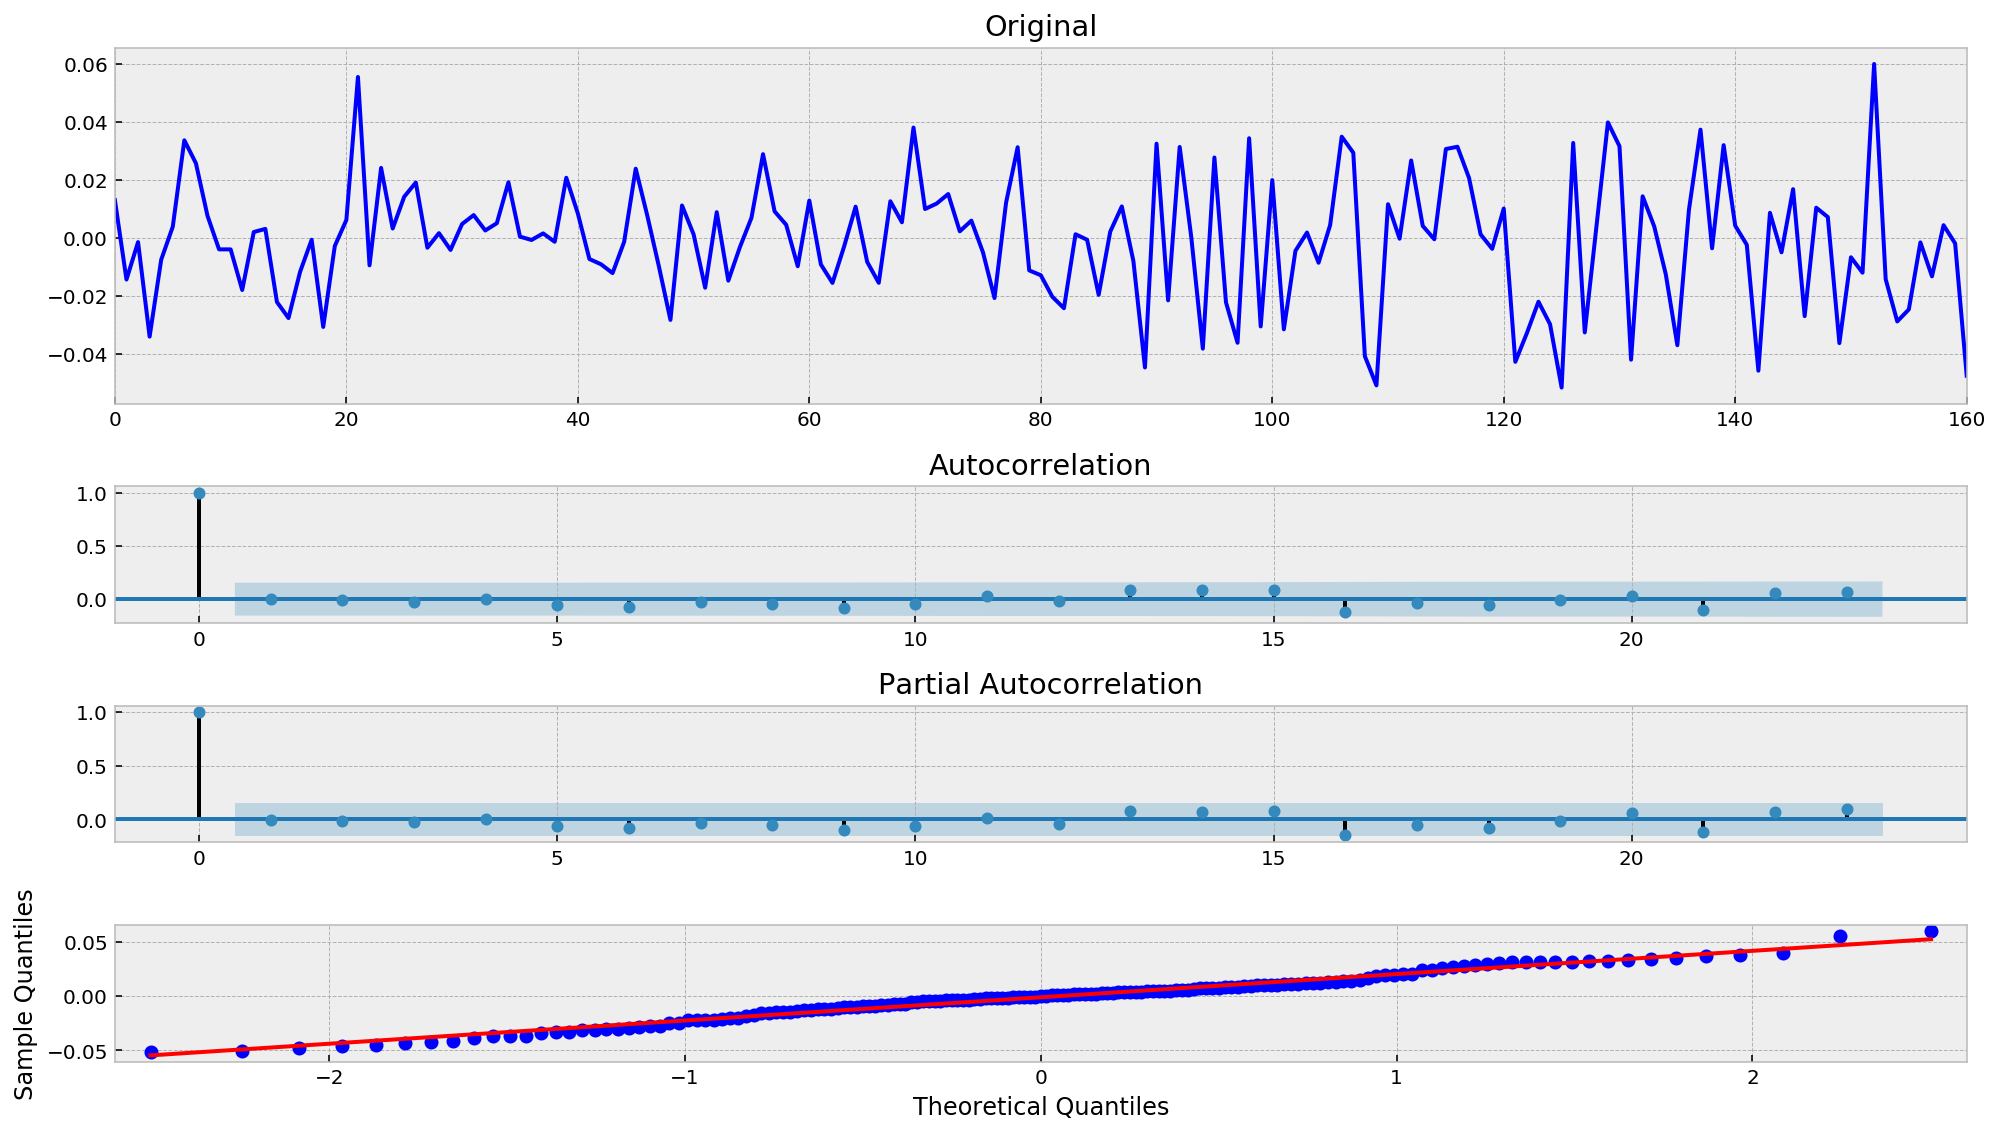

In [13]:
tsplot(mdl.resid)

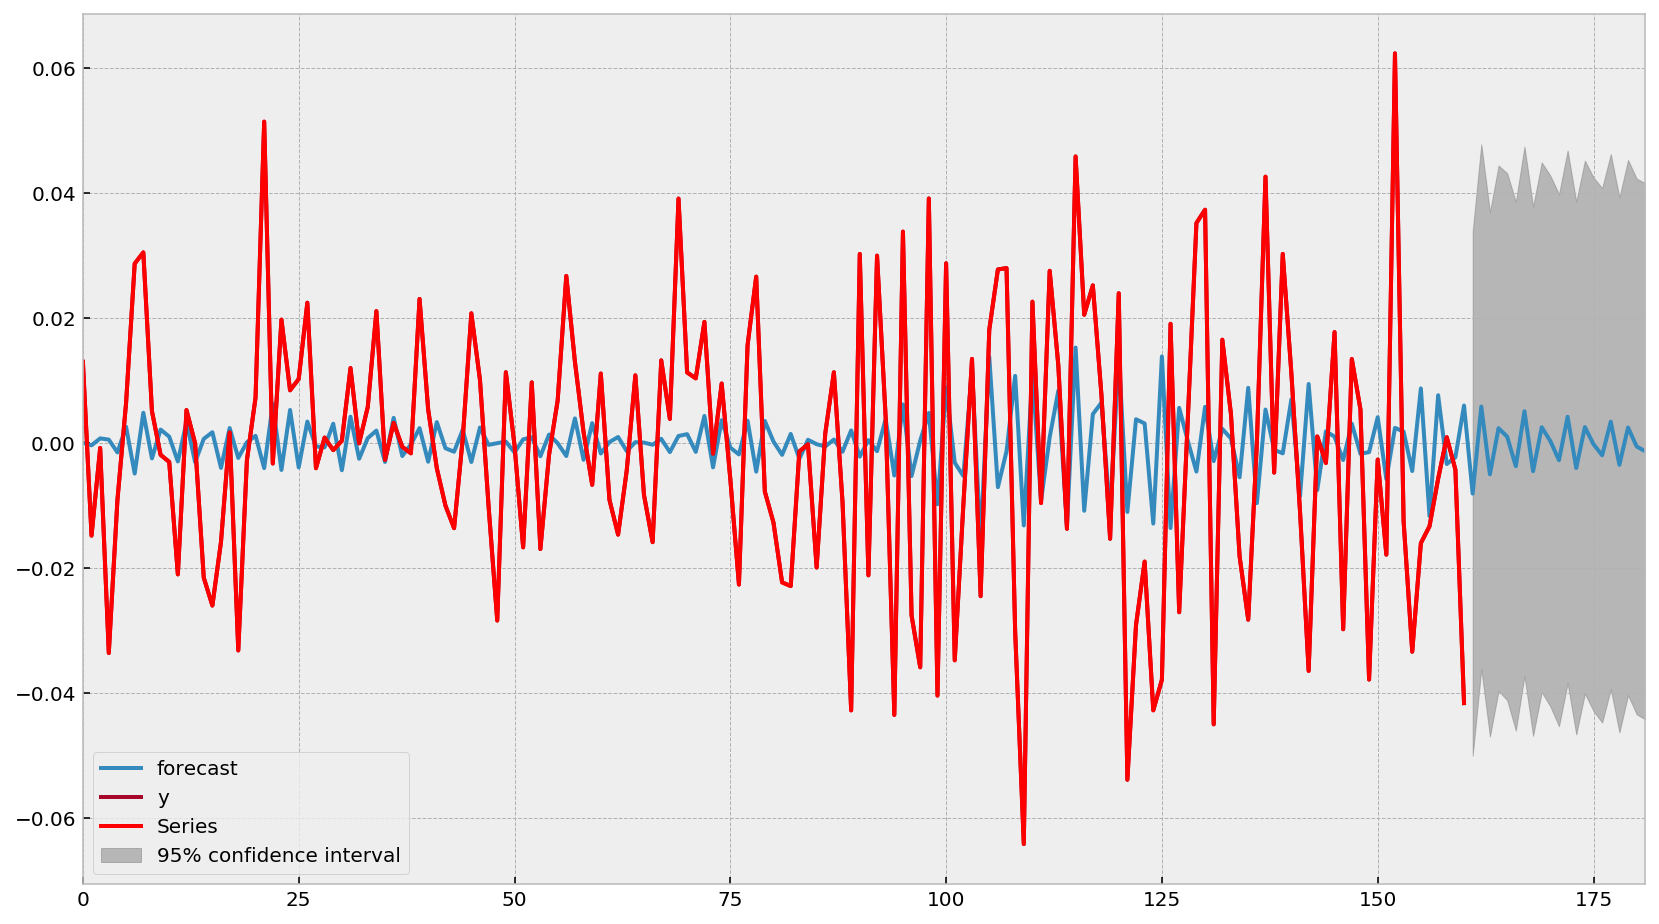

In [43]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

### GARCH

In [25]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.006
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.006
Vol Model:                            GARCH   Log-Likelihood:                395.907
Distribution:      Standardized Student's t   AIC:                          -775.815
Method:                  Maximum Likelihood   BIC:                          -751.163
                                              No. Observations:                  161
Date:                      Tue, Feb 25 2020   Df Residuals:                      153
Time:                              12:35:34   Df Model:                            8
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


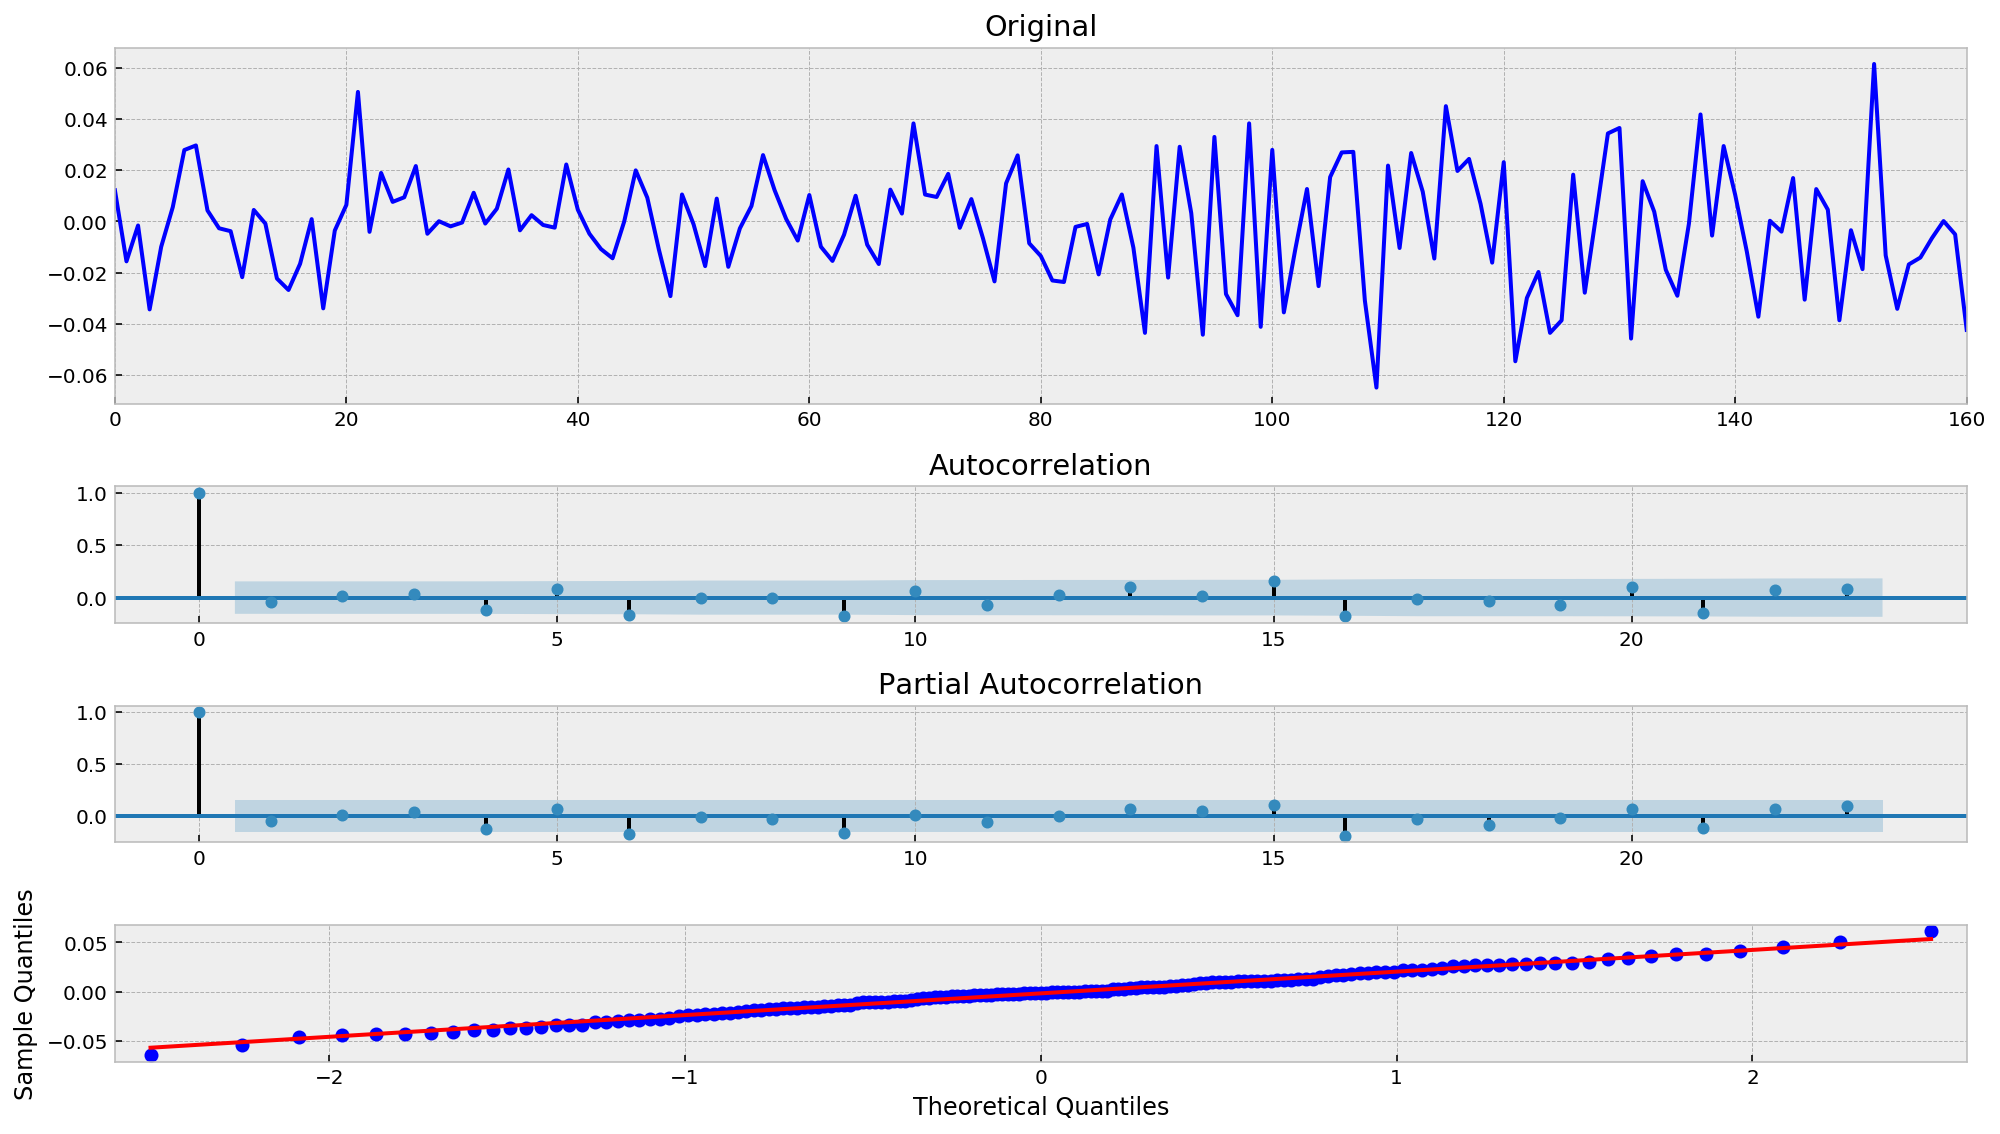

In [26]:
tsplot(res.resid)

### classic machine learning

In [33]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.read_csv("./Series/weekly-closings-of-the-dowjones-.csv")
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test

In [34]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

#### RandomForestRegressor

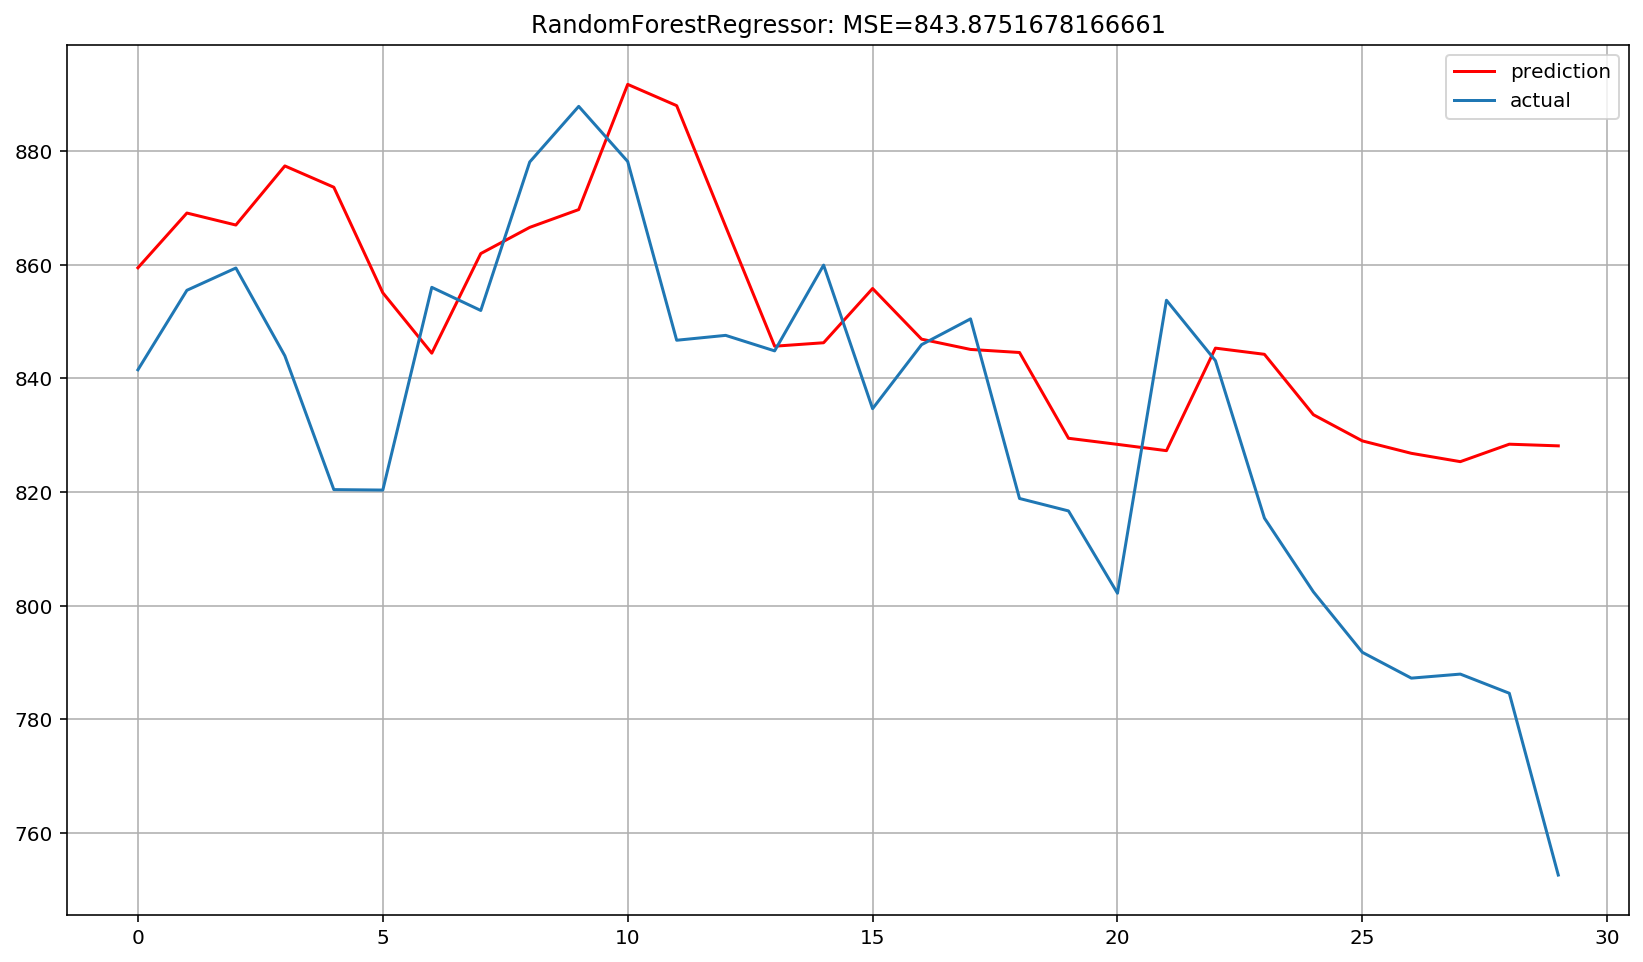

In [51]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=50)
rf.fit(X_train, y_train)
prediction = rf.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title(f"RandomForestRegressor: MSE={mean_squared_error(y_test,prediction)}")
plt.grid(True);

#### LinearRegression

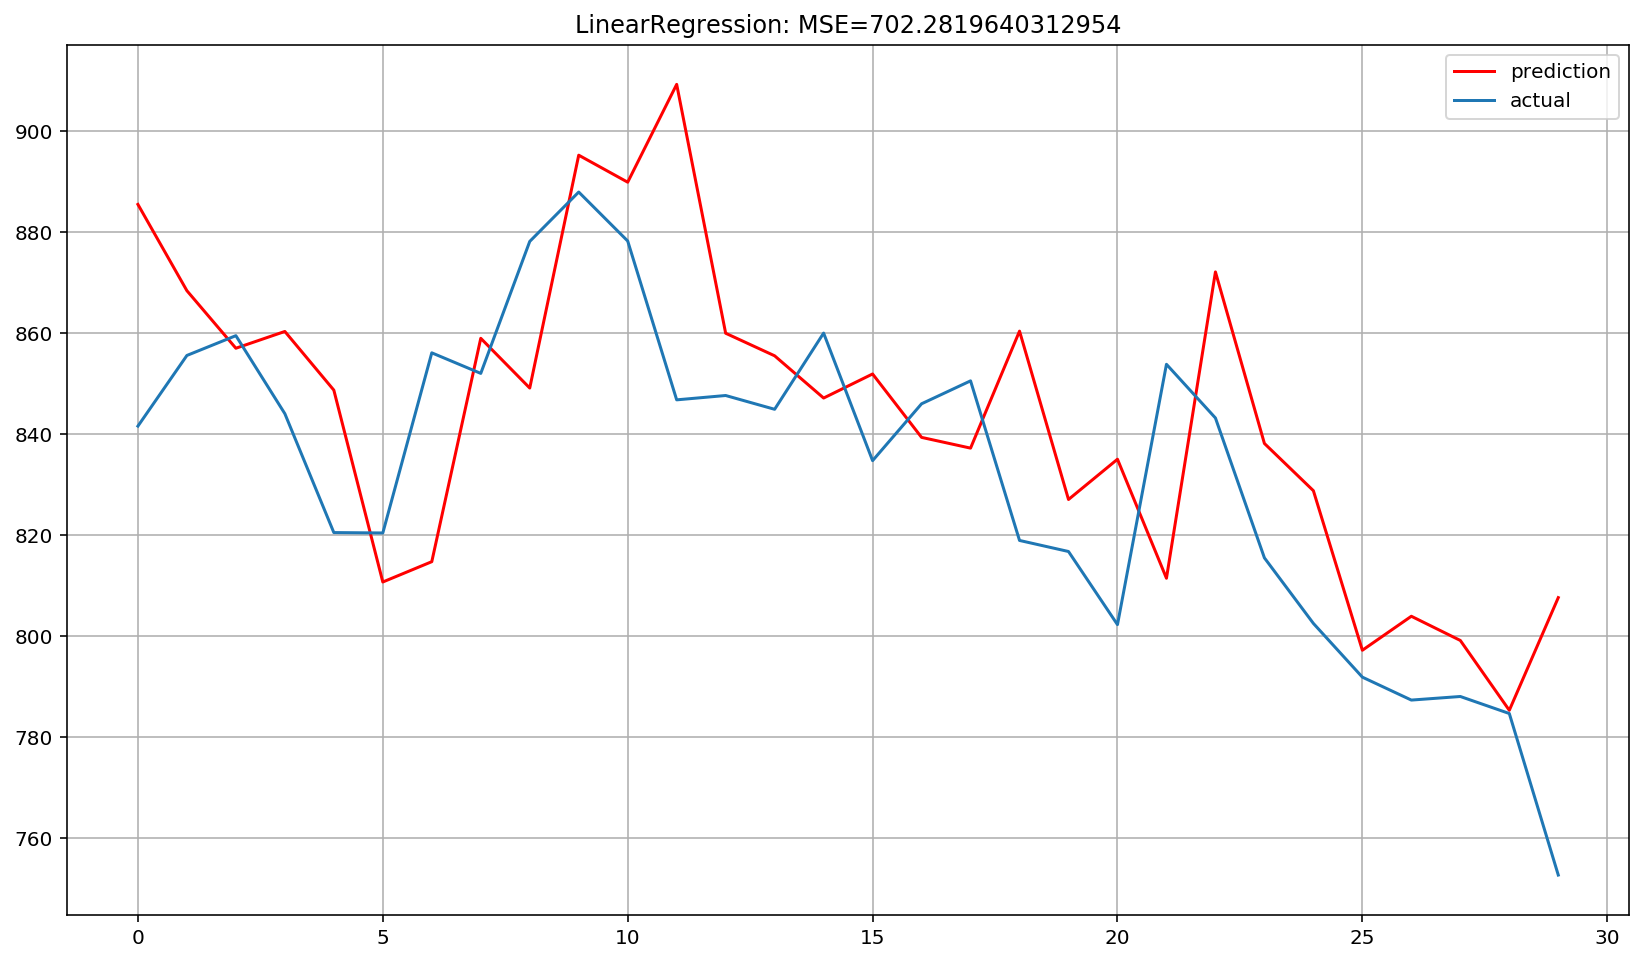

In [48]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
# plt.title("LinearRegression")
plt.title(f"LinearRegression: MSE={mean_squared_error(y_test,prediction)}")
plt.grid(True);

#### AdaBoostRegressor

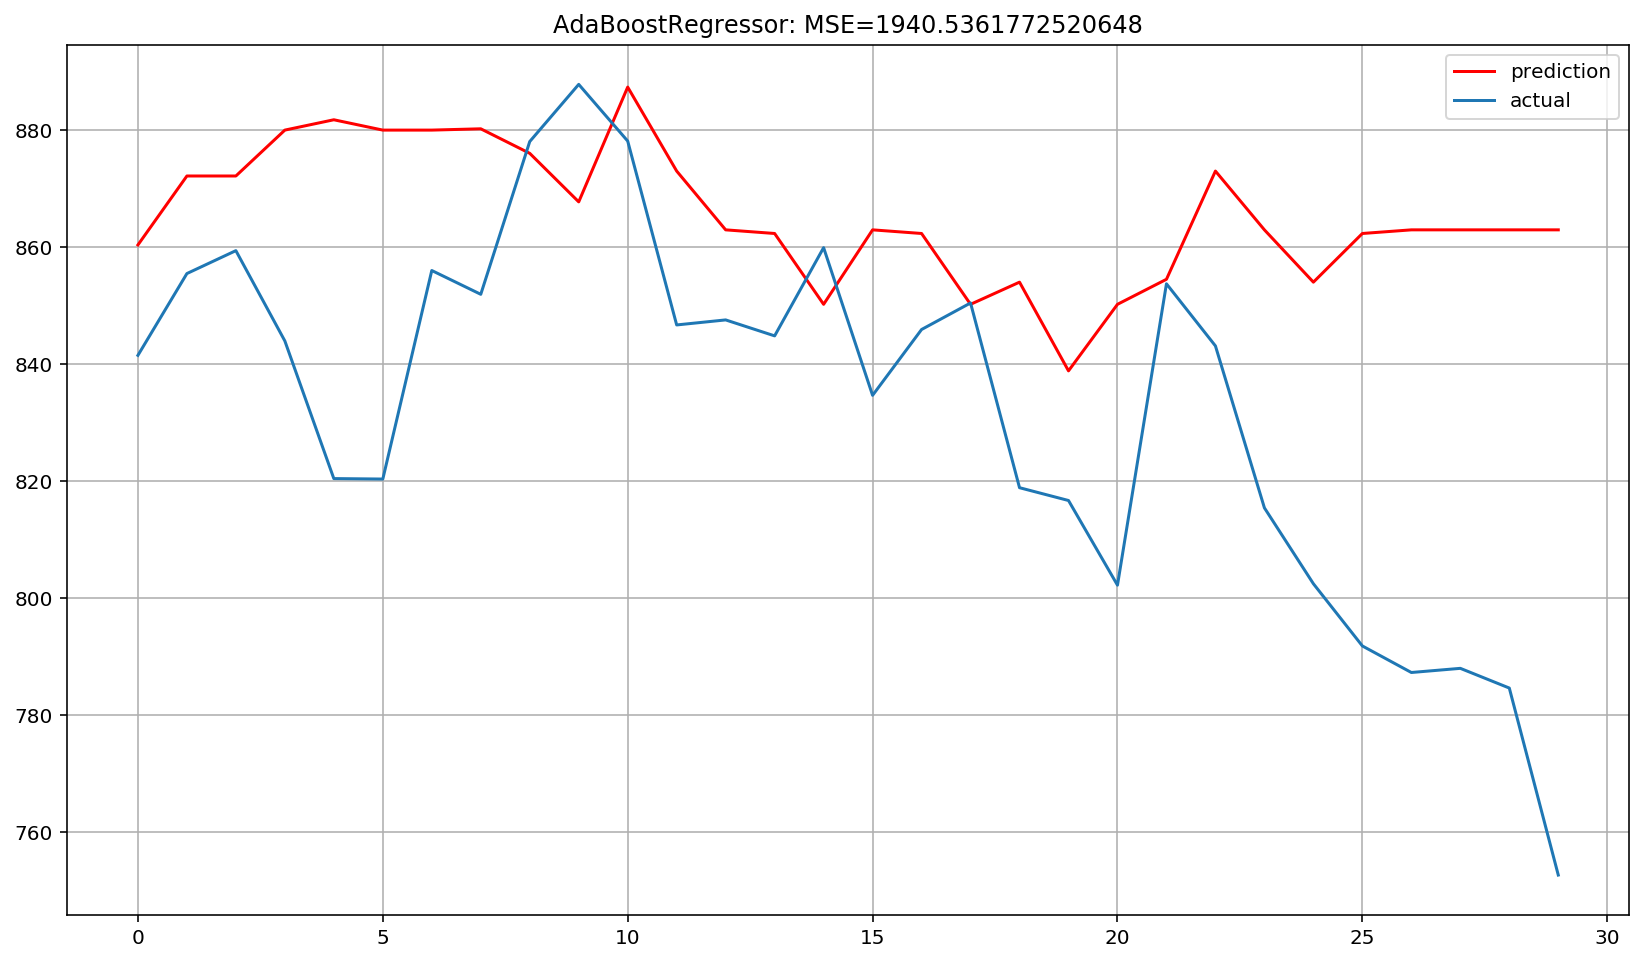

In [49]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

model_ABR = AdaBoostRegressor()
model_ABR.fit(X_train, y_train)
prediction = model_ABR.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
# plt.title("AdaBoostRegressor")
plt.title(f"AdaBoostRegressor: MSE={mean_squared_error(y_test,prediction)}")
plt.grid(True);

#### GradientBoostingRegressor

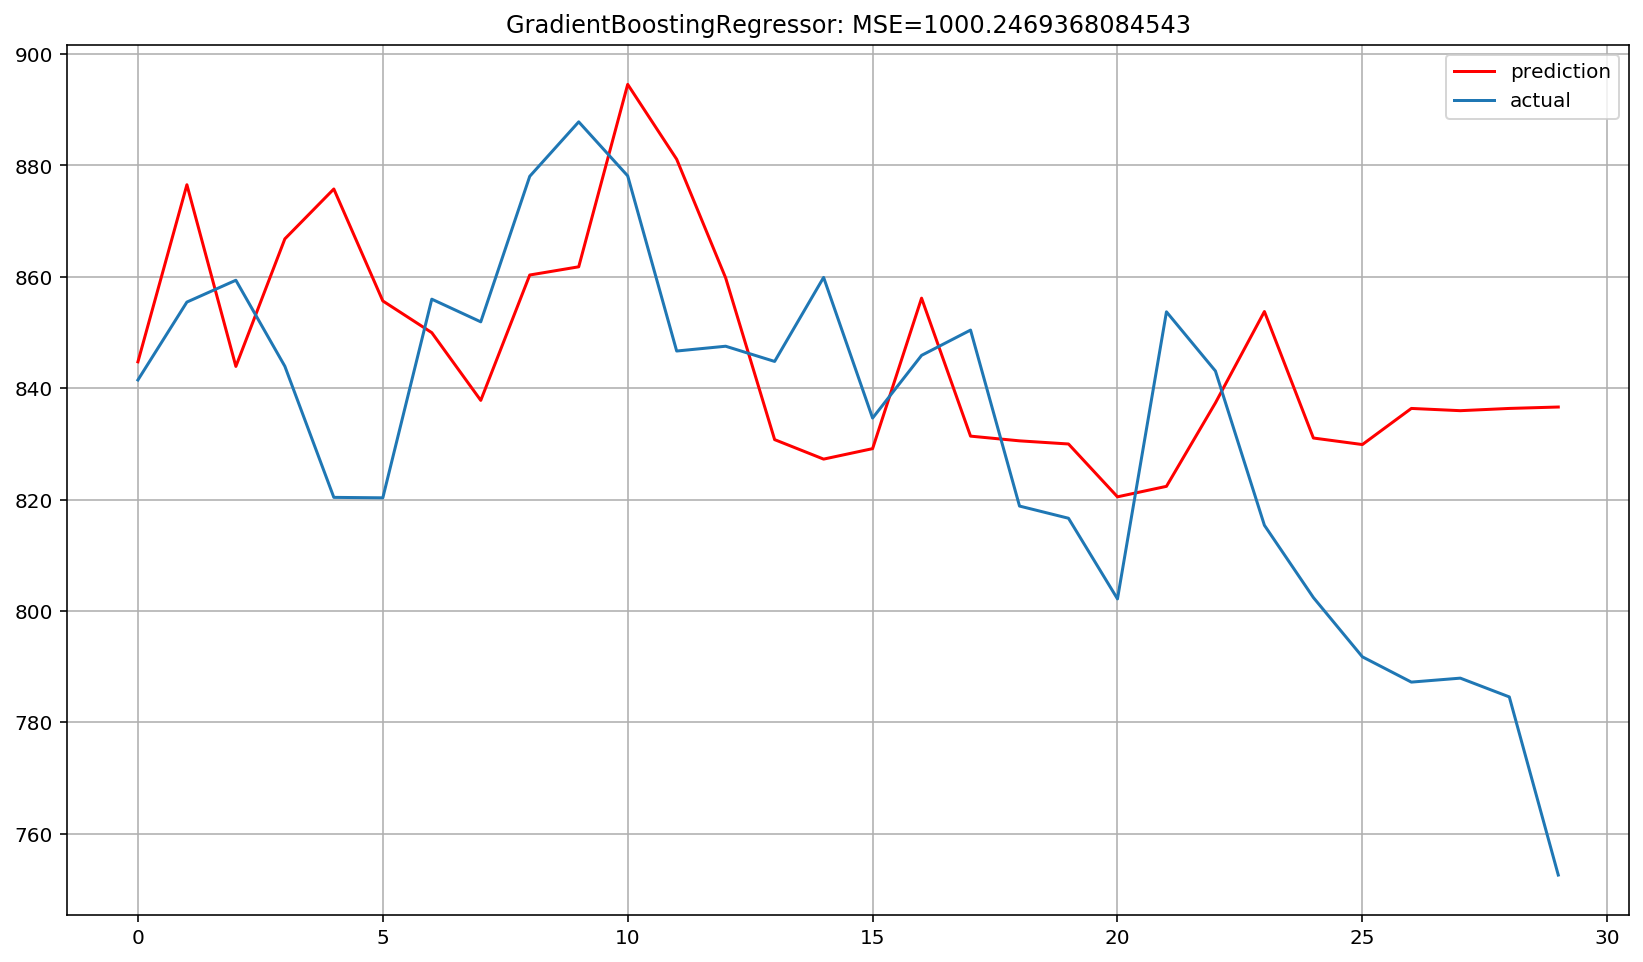

In [50]:
model_GBR = GradientBoostingRegressor()
model_GBR.fit(X_train, y_train)
prediction = model_GBR.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
# plt.title("GradientBoostingRegressor")
plt.title(f"GradientBoostingRegressor: MSE={mean_squared_error(y_test,prediction)}")
plt.grid(True);

- RandomForestRegressor      : MSE=843.875
- LinearRegression           : MSE=703.281
- AdaBoostRegressor          : MSE=1940.53
- GradientBoostingRegressor  : MSE=1000.24

Модель **LinearRegression** дала наиболее лучший результат

In [ ]:
pass